In [1]:
from PIL import Image
import numpy as np
import functools
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt


In [2]:
### Exception used in LFSR implementation

class InvalidPositionException(Exception):
    def __init__(self, position, size):
        message_format = "Position {} must have values in  [0, {}] interval"
        message = message_format.format(position, size - 1)
        super().__init__(self, message)


In [3]:
### LFSR IMPLEMENTATION

def throw_if_invalid_positions(size, positions):
    if len(positions) == 0:
        raise Exception("positions array cannot be empty")

    for position in positions:
        if position > size or position < 0:
            raise InvalidPositionException(position, size)


class LFSR:
    def __init__(self, size=128, state_positions=None, positions_for_next_state=None):
        if positions_for_next_state is None:
            positions_for_next_state = [0, 1, 2, 7]

        if state_positions is None:
            state_positions = [0, 127]

        throw_if_invalid_positions(size, state_positions)
        throw_if_invalid_positions(size, positions_for_next_state)

        self.state = np.array(bytearray(size))
        self.state_positions = state_positions
        self.positions_for_next_state = positions_for_next_state

        for position in state_positions:
            self.state[position] = 0b1

    def get_new_bit(self):
        new_bit = None

        for position in self.positions_for_next_state:
            if new_bit is None:
                new_bit = self.state[position]
            else:
                new_bit ^= self.state[position]

        return new_bit

    def next_state(self):
        new_bit = self.get_new_bit()
        self.state = np.roll(self.state, 1)
        self.state[0] = new_bit

    def get_next_byte(self):
        result = []
        for i in range(0, 8):
            result.append(self.state[0])
            self.next_state()
        return result

In [4]:
### Multi Layer LFSR IMPLEMENTATION

class MultiLayerLFSR:
    def __init__(self, size=128, state_positions=None, positions_for_next_state=None):
        self.lfsr = LFSR(size, state_positions, positions_for_next_state)
        self.stage_functions = [self.stage_one, self.stage_two, self.stage_three]

    def stage_three(self, array):
        random_byte = self.lfsr.get_next_byte()
        return self.bit_array_xor(array, random_byte)

    @staticmethod
    def stage_two(array):
        return list(map(lambda x: 0 if x == 1 else 1, array))

    @staticmethod
    def stage_one(array):
        return np.flip(array)

    @staticmethod
    def bit_array_xor(first_array, second_array):
        return [x ^ y for (x, y) in zip(first_array, second_array)]

    @staticmethod
    def array_from_char_to_int(array):
        return list(map(lambda x: 1 if x == '1' else 0, array))

    @staticmethod
    def array_from_int_to_char(array):
        return "".join(list(map(lambda x: '1' if x == 1 else '0', array)))

    """
        Expects a string of bits e.g. "1010101010"
    """

    def encrypt_decrypt(self, array, encrypt):
        # Chose stage functions order
        if encrypt:
            chosen_stage_functions = self.stage_functions
        else:
            chosen_stage_functions = reversed(self.stage_functions)

        # apply the stage functions
        result = self.array_from_char_to_int(array)
        for stage_function in chosen_stage_functions:
            result = stage_function(result)

        # map result back and return
        return self.array_from_int_to_char(result)


In [5]:
### General purpose helper functions

def from_int_to_bit_string(integer):
    return format(integer, '08b')


def from_bit_string_int(bit_string):
    return int(bit_string, 2)


In [6]:
### image manipulation function

def write_image(data, width, height, file_name):
    image = Image.new(mode="RGB", size=(width, height))
    image.putdata(data)
    image.save(file_name)
    return image

In [7]:
### Wrapper function over MultiLayerLFSR that alows encrypting / decrypting images

def encrypt_decrypt(multi_layer_lfsr, data, encrypt=True):
    for i in range(0, len(data)):
        current_pixel = data[i]
        current_pixel_bit_string = list(map(lambda x: from_int_to_bit_string(x), current_pixel))
        new_pixel_encrypted_bit_string = list(
            map(lambda x: multi_layer_lfsr.encrypt_decrypt(x, encrypt=encrypt), current_pixel_bit_string))
        new_pixel = tuple(map(lambda x: from_bit_string_int(x), new_pixel_encrypted_bit_string))
        data[i] = new_pixel
    return data

In [8]:
initial_image = Image.open('lena.jpeg')

data = list(initial_image.getdata())
width, height = initial_image.size

client = MultiLayerLFSR()
server = MultiLayerLFSR()

print("Encrypting...")
encrypted_data = encrypt_decrypt(client, data, True)
encrypted_image = write_image(encrypted_data, width, height, "encrypted_data.jpeg")

print("Decrypting...")
decrypted_data = encrypt_decrypt(server, encrypted_data, False)
decrypted_image = write_image(decrypted_data, width, height, "decrypted_data.jpeg")

Encrypting...
Decrypting...


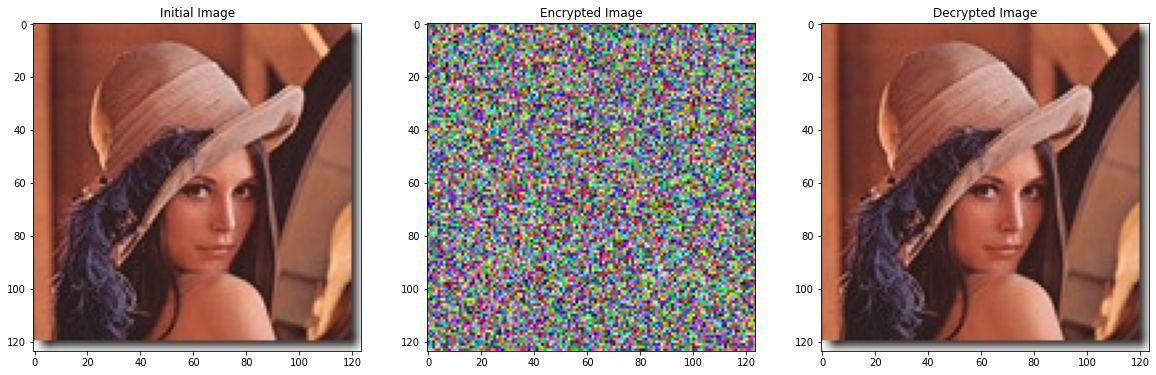

In [9]:
plt.figure(figsize=(20, 10))

plt.subplot(131)
plt.imshow(np.asarray(initial_image))
plt.title("Initial Image")

plt.subplot(132)
plt.imshow(np.asarray(encrypted_image))
plt.title("Encrypted Image")


plt.subplot(133)
plt.imshow(np.asarray(decrypted_image))
plt.title("Decrypted Image")

plt.show()
